In [4]:
import random

def generate_rou_file(context, output_path="context_rou.xml", alpha=0.05):
    """
    Generates a .rou.xml file with flows across all available routes, introducing randomness.

    Args:
        context (str or list of str): Context(s) like 'rainy', 'morning', 'workday'.
        output_path (str): Path to save the generated .rou.xml file.
        alpha (float): Degree of randomness (0 for no randomness, up to 1 for high randomness).

    Returns:
        str: Path to the generated .rou.xml file.
    """
    # Define base routes
    routes = [
        {"id": "route_ns", "edges": "n_t t_s"},
        {"id": "route_nw", "edges": "n_t t_w"},
        {"id": "route_ne", "edges": "n_t t_e"},
        {"id": "route_we", "edges": "w_t t_e"},
        {"id": "route_wn", "edges": "w_t t_n"},
        {"id": "route_ws", "edges": "w_t t_s"},
        {"id": "route_ew", "edges": "e_t t_w"},
        {"id": "route_en", "edges": "e_t t_n"},
        {"id": "route_es", "edges": "e_t t_s"},
        {"id": "route_sn", "edges": "s_t t_n"},
        {"id": "route_se", "edges": "s_t t_e"},
        {"id": "route_sw", "edges": "s_t t_w"},
    ]

    # Base flow parameters
    base_flow = {
        # Time-based contexts
        "morning": {"vehsPerHour": 600, "adjustment": 1.0},  # Morning has high traffic
        "midday": {"vehsPerHour": 400, "adjustment": 0.8},   # Midday has moderate traffic
        "evening": {"vehsPerHour": 700, "adjustment": 1.1},  # Evening has the highest traffic
        "night": {"vehsPerHour": 200, "adjustment": 0.5},    # Night has low traffic

        # Weather-based contexts
        "rainy": {"adjustment": 0.7},                       # Traffic flow decreases in rain
        "warm": {"adjustment": 1.0},                        # Normal traffic flow in warm weather
        "windy": {"adjustment": 0.9},                       # Slightly reduced flow in windy weather
        "hew": {"adjustment": 0.8},                         # Reduced flow in hew (humid and windy)

        # Day-based contexts
        "holiday": {"adjustment": 0.5},                     # Traffic significantly reduces on holidays
        "workday": {"adjustment": 1.3},                     # Higher traffic on workdays
    }


    # Default settings
    vehs_per_hour = 400
    adjustment = 1.0
    start = 0
    end = 7200

    # Apply context adjustments
    if isinstance(context, list):
        for ctx in context:
            if ctx in base_flow:
                if "vehsPerHour" in base_flow[ctx]:
                    vehs_per_hour = base_flow[ctx]["vehsPerHour"]
                if "adjustment" in base_flow[ctx]:
                    adjustment *= base_flow[ctx]["adjustment"]
    elif context in base_flow:
        if "vehsPerHour" in base_flow[context]:
            vehs_per_hour = base_flow[context]["vehsPerHour"]
        if "adjustment" in base_flow[context]:
            adjustment *= base_flow[context]["adjustment"]

    # Adjust base flow rate
    base_flow_rate = int(vehs_per_hour * adjustment)

    # Write .rou.xml file
    with open(output_path, "w") as file:
        file.write("<routes>\n")

        # Add routes
        for route in routes:
            file.write(f'    <route id="{route["id"]}" edges="{route["edges"]}"/>\n')

        # Add flows with randomness
        for route in routes:
            # Introduce randomness to the flow rate
            random_factor = 1 + random.uniform(-alpha, alpha)  # Scale by (1 ± alpha)
            flow_rate = int(base_flow_rate * random_factor)
            file.write(
                f'    <flow id="flow_{route["id"]}" route="{route["id"]}" '
                f'begin="{start}" end="{end}" vehsPerHour="{flow_rate}" '
                f'departSpeed="max" departLane="best"/>\n'
            )

        file.write("</routes>\n")

    return output_path


In [18]:
import os

context_weights = {
        "morning": {"pressure": 0.3, "avg_speed": 0.4, "queue": -0.3, "diff_wait_time": 0.2},
        "midday": {"pressure": 0.2, "avg_speed": 0.5, "queue": -0.1, "diff_wait_time": 0.1},
        "evening": {"pressure": 0.2, "avg_speed": 0.3, "queue": -0.3, "diff_wait_time": 0.2},
        "night": {"pressure": 0.1, "avg_speed": 0.6, "queue": -0.1, "diff_wait_time": 0.1},
        "rainy": {"pressure": 0.4, "avg_speed": 0.3, "queue": -0.2, "diff_wait_time": 0.1},
        "warm": {"pressure": 0.2, "avg_speed": 0.4, "queue": -0.2, "diff_wait_time": 0.2},
        "windy": {"pressure": 0.3, "avg_speed": 0.3, "queue": -0.3, "diff_wait_time": 0.1},
        "hew": {"pressure": 0.4, "avg_speed": 0.2, "queue": -0.2, "diff_wait_time": 0.1},
        "holiday": {"pressure": 0.1, "avg_speed": 0.5, "queue": -0.3, "diff_wait_time": 0.1},
        "workday": {"pressure": 0.2, "avg_speed": 0.3, "queue": -0.3, "diff_wait_time": 0.2},
    }

class Context:
    def __init__(self, context_name, rou_path, alpha=0.1):
        """
        Initialize a context with its name and rou.xml path.

        Args:
            context_name (str or list of str): The name(s) of the context (e.g., 'morning', 'rainy').
            rou_path (str): Path to the generated .rou.xml file.
            alpha (float): Degree of randomness for route generation.
        """
        self.name = context_name if isinstance(context_name, list) else [context_name]
        self.rou_path = rou_path
        self.alpha = alpha

        # Check if rou.xml exists, generate if not
        if not os.path.exists(self.rou_path):
            print(f"File {self.rou_path} not found. Generating...")
            generate_rou_file(self.name, self.rou_path, alpha=self.alpha)

    def reward_weights(self):
        """
        Outputs the weights for the reward function based on the context.

        Returns:
            dict: Averaged weights for the given context(s).
        """

        # Default weights for unknown contexts
        default_weights = {"pressure": 0, "avg_speed": 0, "queue": 0, "diff_wait_time": 1}

        # Calculate averaged weights for multiple contexts
        combined_weights = default_weights.copy()
        for ctx in self.name:
            weights = context_weights.get(ctx, default_weights)
            for key in combined_weights:
                combined_weights[key] += weights[key]

        # Average weights over the number of contexts
        num_contexts = len(self.name)
        averaged_weights = {key: value / num_contexts for key, value in combined_weights.items()}

        return averaged_weights


In [27]:
from sumo_rl import SumoEnvironment

class SUMOContextualEnv(SumoEnvironment):
    def change_context_reward_weight(self, pw=0, asw=0, dww=1, tqw=-1, weight_dict = None):
        if weight_dict is not None:
            pw = weight_dict.get('pressure', 0)
            asw = weight_dict.get('avg_speed', 0)
            dww = weight_dict.get('diff_wait_time', 1)
            tqw = weight_dict.get('queue', -1)
        self.pressure_weight = pw
        self.avg_speed_weight = asw
        self.diff_wait_weight = dww
        self.total_queue_weight = tqw

    def _compute_rewards(self):
        self.rewards.update(
            {
                ts: self._process_ts_reward(ts)
                for ts in self.ts_ids
                if self.traffic_signals[ts].time_to_act or self.fixed_ts
            }
        )
        return {ts: self.rewards[ts] for ts in self.rewards.keys() if self.traffic_signals[ts].time_to_act or self.fixed_ts}
    
    def _process_ts_reward(self, ts):
        reward = self.pressure_weight * self.traffic_signals[ts].get_pressure()
        reward += self.avg_speed_weight * self.traffic_signals[ts].get_average_speed()
        reward += self.total_queue_weight * self.traffic_signals[ts].get_total_queued()
        if self.diff_wait_weight != 0:
            ts_wait = sum(self.traffic_signals[ts].get_accumulated_waiting_time_per_lane()) / 100.0
            reward += self.diff_wait_weight * (self.traffic_signals[ts].last_measure - ts_wait)
            self.traffic_signals[ts].last_measure = ts_wait
        reward = reward / 100
        self.traffic_signals[ts].last_reward = reward
        return reward

In [28]:
base_path = './nets/2way-single-intersection/single-intersection'

In [29]:
context_morning = Context('morning', base_path+'_morning.rou.xml')

In [30]:
sumo_env_morning = SUMOContextualEnv(
    net_file=base_path+'.net.xml',
    route_file=context_morning.rou_path,
    out_csv_name=f'./outputs/morning/out', 
    single_agent = True,
    use_gui=False,
    num_seconds=1000
)
sumo_env_morning.change_context_reward_weight(weight_dict=context_morning.reward_weights())

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 0 ACT 0 BUF 0)                     


In [31]:
from stable_baselines3.dqn.dqn import DQN
import torch

In [32]:
sumo_env_morning.reset()
model_morning = DQN(
    env=sumo_env_morning,
    policy="MlpPolicy",
    learning_rate=1e-3,
    learning_starts=0,
    train_freq=1,
    target_update_interval=500,
    exploration_initial_eps=0.05,
    exploration_final_eps=0.01,
    verbose=1,
    device = torch.device('mps')
)
model_morning.learn(total_timesteps=5000)
model_morning.save(f'./experts/dqn_morning.pth')

 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 893 ACT 143 BUF 1121)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 41ms, vehicles TOT 856 ACT 143 BUF 1158)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 872 ACT 144 BUF 1142)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 856 ACT 144 BUF 1158)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 19       |
|    time_elapsed     | 41    

In [33]:
def eval_DQN(sumo_env, model,  max_iter = 1000):
    obs, info = sumo_env.reset()
    total_reward = 0
    info_dump = []
    for _ in range(max_iter):
        with torch.no_grad():
            action, meta = model.predict(obs)
        obs, reward, done, trunc, info = sumo_env.step(action)
        total_reward += reward
        info_dump.append(info)
        if done:
            break
    return total_reward, info_dump

In [34]:
eval_DQN(sumo_env_morning, model_morning)

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 13351ms, vehicles TOT 0 ACT 0 BUF 0)                  
 Retrying in 1 seconds


(-655.8400202520065,
 [{'step': 5.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 12.950398442681369,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.9345156157607765,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 10.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 12.820358345554217,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.9256229810034134,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 15.0,
   'system_total_stopped': 6,
   'system_total_waiting_time': 7.0,
   'system_mean_waiting_time': 0.19444444444444445,
   'system_mean_speed': 9.806130000852455,
   't_stopped': 6,
   't_accumulated_waiting_time': 7.0,
   't_average_speed': 0.6838811370391213,
   'agents_total

In [37]:
def make_context_env(ctx):
    ctx_name = '_'.join(ctx)
    context = Context(ctx_name, f'{base_path}{ctx_name}.rou.xml')
    sumo_env = SUMOContextualEnv(
        net_file=base_path+'.net.xml',
        route_file=context.rou_path,
        out_csv_name=f'./outputs/{ctx_name}/out', 
        single_agent = True,
        use_gui=False,
        num_seconds=1000
    )
    sumo_env.change_context_reward_weight(weight_dict=context.reward_weights())
    return context, sumo_env

In [38]:
def train_DQN(sumo_env, context):
    sumo_env.reset()
    model = DQN(
        env=sumo_env,
        policy="MlpPolicy",
        learning_rate=1e-3,
        learning_starts=0,
        train_freq=1,
        target_update_interval=500,
        exploration_initial_eps=0.05,
        exploration_final_eps=0.01,
        verbose=1,
        device = torch.device('mps')
    )
    model_morning.learn(total_timesteps=5000)
    model_morning.save(f'./experts/dqn{context.name}.pth')
    return model

In [39]:
ctx_evening, sumo_env_evening = make_context_env(['evening'])

File ./nets/2way-single-intersection/single-intersectionevening.rou.xml not found. Generating...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [40]:
model_evening = train_DQN(sumo_env_evening, ctx_evening)

 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #5000.00 (1ms ~= 1000.00*RT, ~141000.00UPS, TraCI: 548334ms, vehicles TOT 4413 ACT 14
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 952 ACT 144 BUF 1062)             
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~143000.00UPS, TraCI: 41ms, vehicles TOT 915 ACT 143 BUF 
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 935 ACT 144 BUF 1079)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 47ms, vehicles TOT 922 ACT 143 BUF 1092)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 18       |
|    time_elapsed     | 43   

In [41]:
ctx_midday, sumo_env_midday = make_context_env(['midday'])
model_midday = train_DQN(sumo_env_midday, ctx_midday)

File ./nets/2way-single-intersection/single-intersectionmidday.rou.xml not found. Generating...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 2262ms, vehicles TOT 0 ACT 0 BUF 0)                   
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 41ms, vehicles TOT 984 ACT 142 BUF 1030)             
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~145000.00UPS, TraCI: 41ms, vehicles TOT 950 ACT 145 BUF 
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 985 ACT 144 BUF 1029)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 950 ACT 140 BUF 1064)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200    

In [42]:
ctx_night, sumo_env_night = make_context_env(['night'])
model_night = train_DQN(sumo_env_night, ctx_night)

File ./nets/2way-single-intersection/single-intersectionnight.rou.xml not found. Generating...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 2214ms, vehicles TOT 0 ACT 0 BUF 0)                   
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 41ms, vehicles TOT 955 ACT 145 BUF 1059)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 981 ACT 142 BUF 1033)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 40ms, vehicles TOT 952 ACT 138 BUF 1062)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 36ms, vehicles TOT 955 ACT 125 BUF 1059)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200     

In [44]:
all_rew_table = []
for mdl in {model_morning, model_midday, model_evening, model_night}:
    mdl_table = []
    for senv in [sumo_env_morning, sumo_env_midday, sumo_env_evening, sumo_env_night]:
        rew, _ = eval_DQN(senv, mdl)
        mdl_table.append(rew)
    all_rew_table.append(mdl_table)

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 263062ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 774055ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 1082177ms, vehicles TOT 0 ACT 0 BUF 0)                
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 613364ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~121000.00UPS, TraCI: 122337ms, vehicles TOT 1736 ACT 12
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~118000.00UPS, TraCI: 127107ms, vehicles TOT 990 ACT 118
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~124000.00UPS, TraCI: 124190ms, vehicles TOT 2349 ACT 12
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 133287ms, vehicles TOT 408 ACT 116 BUF 1312)        
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~131000.00UPS, TraCI: 125786ms, vehicles TOT 3537 ACT 13
 

In [45]:
all_rew_table

[[-692.2930102813096,
  -350.0696208645256,
  -579.5338334778097,
  -230.8649596948829],
 [-692.0167084648393,
  -348.86471594387507,
  -580.7719579687674,
  -228.30447271487574],
 [-487.3151963317896,
  -241.416527249696,
  -488.0337575105387,
  -158.79631848533288],
 [-652.7499917544856,
  -283.375953430824,
  -547.3151123894811,
  -182.1897420236837]]

In [46]:
import matplotlib.pyplot as plt
import numpy as np

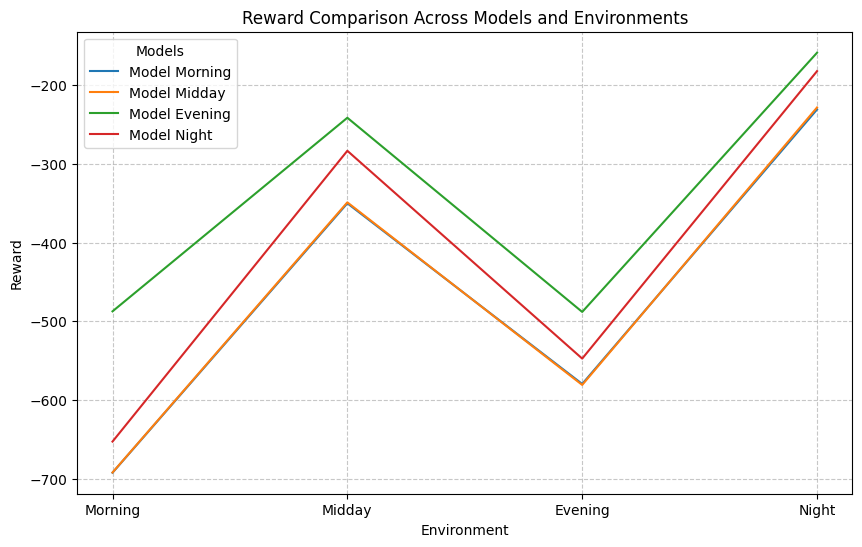

In [47]:
environments = ["Morning", "Midday", "Evening", "Night"]

# Plotting the rewards
plt.figure(figsize=(10, 6))

for i, model_rewards in enumerate(all_rew_table):
    plt.plot(environments, model_rewards, label=f"Model {environments[i]}")

plt.title("Reward Comparison Across Models and Environments")
plt.xlabel("Environment")
plt.ylabel("Reward")
plt.legend(title="Models")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [43]:
from torch import nn
import torch.nn.functional as F

In [57]:
class WeightedMOE(nn.Module):
    def __init__(self, context_size,  num_expert, experts, device=torch.device('cpu')):
        super().__init__()
        self.gating_network = nn.Sequential(
            nn.Linear(context_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_expert)
        ).to(device)
        self.experts = [DQN.load(path) for prob, path in experts.items()]
        self.device = device

    def forward(self, context:Context):
        """_summary_

        Args:
            context (_type_): _description_
            obs (_type_): _description_

        Returns:
            _type_: _description_
        """
        ctx = torch.tensor(list(context.reward_weights().values())).view(1, -1).to(self.device)
        return F.softmax(self.gating_network(ctx), dim=-1)
    
    def get_expert(self, context):
        with torch.no_grad():
            exp_idx = self.forward(context).argmax().item()
        return self.experts[exp_idx]

    def predict(self, context, obs):
        exp_idx = self.forward(context).argmax().item()
        return self.experts[exp_idx].predict(obs)

In [62]:
experts = {}
wmoe = WeightedMOE(4, 4, experts, torch.device('mps'))
wmoe.experts = [model_morning, model_midday, model_evening, model_night]

In [63]:
optim = torch.optim.SGD(wmoe.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [64]:
loss_log = []
rew_log = []
for epoch in range(10):
    for senv, ctx in zip(
        [sumo_env_morning, sumo_env_midday, sumo_env_evening, sumo_env_night],
        [context_morning, ctx_midday, ctx_evening, ctx_night]
    ):
        obs, info = senv.reset()
        cum_reward = 0
        for _ in range(100):
            expert_prob = wmoe(ctx)
            exp_rew = []
            for mdl in {model_morning, model_midday, model_evening, model_night}:
                rew, _ = eval_DQN(model=mdl, sumo_env=senv, max_iter=100)
                exp_rew.append(rew)
            exp_rew = F.softmax(torch.tensor(exp_rew).view(1, -1), dim=-1).to(torch.device('mps'))
            optim.zero_grad()
            loss = criterion(expert_prob, exp_rew)
            loss.backward()
            optim.step()
            with torch.no_grad():
                action, meta = wmoe.predict(ctx, torch.from_numpy(obs))
            obs, reward, done, trunc, info = senv.step(action)
            if done:
                break
            loss_log.append(loss.item())
            rew_log.append(reward)
            cum_reward += reward
        print(f'training epoch{epoch} context {ctx.name} reward {cum_reward} moe loss {loss.item()}')

Step #500.00 (0ms ?*RT. ?UPS, TraCI: 27318ms, vehicles TOT 541 ACT 141 BUF 468)           
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 278 ACT 122 BUF 731)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 459 ACT 130 BUF 550)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 415 ACT 97 BUF 594)               
 Retrying in 1 seconds
Step #505.00 (0ms ?*RT. ?UPS, TraCI: 52ms, vehicles TOT 550 ACT 127 BUF 469)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 36ms, vehicles TOT 279 ACT 122 BUF 730)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 457 ACT 128 BUF 552)              
 Retrying in 1 seconds
Step #500.00 (1ms ~= 1000.00*RT, ~98000.00UPS, TraCI: 28ms, vehicles TOT 413 ACT 98 BUF 5

KeyboardInterrupt: 

In [73]:
ctx_morning_rainy, sumo_env_morning_rainy = make_context_env(['morning', 'rainy'])

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 0 ACT 0 BUF 0)                     


In [74]:
wmoe(ctx_morning_rainy)

tensor([[0.2310, 0.2245, 0.3988, 0.1456]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)